## QQ 群数据分析
### 一点点思考：    
#### 数据本身：   
数据有 id 和时间两列。仔细看数据，很多用户隔几秒就会再出现一次。所以，基本可以肯定表格中的时间是聊天时间，而非成员的登陆时间。   
#### 但问题也随之而来了：聊天时间不能代表哪些内容？  
1. 聊天时间记录并不足以推断出 QQ 群人数，因为很可能有人进群后就一句话也没说过。  
2. 很难看出群人数的详细变化   
第二年说话的人减少，但无法得知，人减少是因为有人被剔除群聊了呢，还是老用户不愿意说话了。

#### QQ 群数据可能说明的内容
1. 用户活跃度
2. 推测群类型

In [145]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

#### 瞟一眼数据量

In [97]:
!wc -l qqdata.csv

   11563 qqdata.csv


### 读取数据和简单处理下时间数据

In [29]:
qq_group = pd.read_csv('qqdata.csv', names=["id", "time"], header=0)
# 把时间转为pandas index可用的datetime格式
qq_group.index = pd.to_datetime(qq_group['time'], unit='s')
qq_group= qq_group[[0]]
# 设置一个无关紧要的列，后面排序会用到
qq_group['num'] = range(11562)
# 查看表头表尾
qq_group[0:3].append(qq_group[-3::])

,id,num
time,,
2011-07-08 12:11:13,8cha0,0
2011-07-08 12:11:49,2cha061,1
2011-07-08 12:13:36,6cha437,2
2012-11-30 18:27:43,6cha437,11559
2012-11-30 18:28:24,7cha1,11560
2012-11-30 18:28:28,7cha1,11561


### 依据年，月，周，日，小时，对数据取子集

In [32]:
qq_group['year'] = qq_group.index.map(lambda x : x.year)
qq_group['month'] = qq_group.index.map(lambda x : x.month)
qq_group['weekday'] = qq_group.index.map(lambda x : x.weekday)
qq_group['day'] = qq_group.index.map(lambda x : x.date)
qq_group['hour'] = qq_group.index.map(lambda x : x.hour)

#### 查看总活跃人数

In [187]:
len(qq_group['id'].unique())

144

#### 查看各年度活跃人数

In [15]:
year_people = qq_group.groupby('year').id.nunique().\
                sort_values(ascending=False).sort_index()
year_people

year
2011    115
2012     92
Name: id, dtype: int64

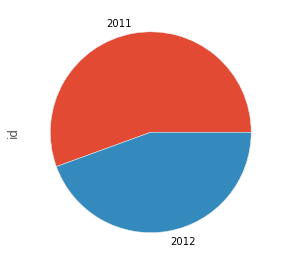

In [274]:
year_people.plot.pie(figsize=(4.5, 4.5))

###  2011 年到 2012 年，活跃人数发生了什么变化
 2011 年活跃人数为 115 人， 2012 年活跃人数为 92 人。    
同时，总活跃人数为 144 人，这不一定说明有很多人被剔出群聊了，而是说明：   
- 2012 年，有 29 个新的活跃人数 ( 144 - 115 = 29 ) ，这 29 个人很可能是新用户。虽然也可能有人隔了半年不说话，某天心血来潮来唠嗑... 
- 2012 年，有 63 个老用户仍继续活跃 ( 92 - 29 )，有 52 个在 2011 年活跃过的用户不再参与群聊 ( 115 - 63 )    

下面用代码来检查一下推测

In [36]:
# 取2011年，2012年两个子集
year2011 = qq_group[qq_group['year'].apply(lambda x : x == 2011)]
year2012 = qq_group[qq_group['year'].apply(lambda x : x == 2012)]
# 查看11年，12年的活跃人数
year_people_11 = list(year2011['id'].unique())
year_people_12 = list(year2012['id'].unique())
# 对11年，12年人数数据取交集，得到的数字为从11年活跃到12年的用户人数
len(list(set(year_people_11).intersection(set(year_people_12))))

63

###  2011 年、2012 年 QQ 群月活跃人数
#### 活跃人数  
- 12 年和 11 年相比，活跃人数减少了许多。
- 12 年有记录的最后四个月，说话人数不到建群第一个月人数的三分之一。   
可能因为大家开始用微信咯

In [113]:
# 查看每月活跃人数
month_people_11 = year2011.groupby('month').id.nunique().\
                sort_values(ascending=False).sort_index()
month_people_12 = year2012.groupby('month').id.nunique().\
                sort_values(ascending=False).sort_index()
month_people_12

month
1     46
2     24
3     46
4     40
5     44
6     34
7     33
8      6
10    15
11    19
Name: id, dtype: int64

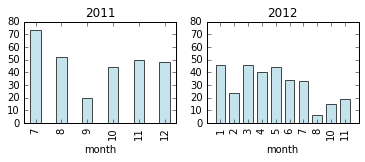

In [245]:
fig = plt.figure()
ax2 = fig.add_subplot(222)
month_people_12.plot.bar(color = 'lightblue', width=0.7, title = '2012', alpha=0.7)
ax2.set_yticks(range(0,90,10))
plt.xlim(-1, 10)
ax1 = fig.add_subplot(221)
month_people_11.plot.bar(color = 'lightblue', width=0.4, title = '2011', alpha=0.7)

### 群类型猜测
脑补一下，这是个跟学校有关的工作群咩？寒暑假不见面都不怎么说话
-  2 月和 9 月是活跃人数的波谷，12 年 9 月更是一句话也没人说    
-  每年暑假 7月、8 月说话人数渐渐减少      

#### 下面看看分星期和小时的活跃情况
是不是工作群呢？看看大家平时聊天的时间分布

#### 分星期
大多数对话都发生在工作日，一定程度上说明，这个群不是用来休闲娱乐的

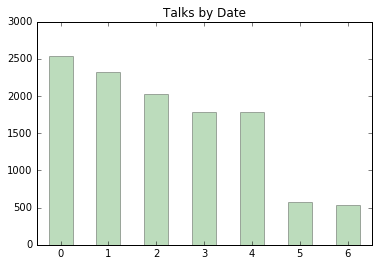

In [241]:
wd = qq_group.weekday.value_counts().sort_index()
wd.plot.bar(color= 'forestgreen', alpha = 0.3, rot=0, title= 'Talks by Date')

#### 分小时
- 主要聊天时间集中在上午10点到11点，和下午2点到6点，正好是上班的时候
- 午休和晚饭时间没人说话，大家都次饭去了，不在工作群聊正事诶
- 晚上12点以后到上午9点，没有任何人说话，说明这也不是深夜情感交流群~


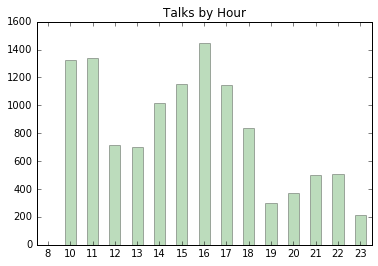

In [242]:
hour = qq_group.hour.value_counts().sort_index()
hour.plot.bar(color= 'forestgreen', alpha = 0.3, rot=0, title = 'Talks by Hour')

#### 结合上述信息推测，这个群可能是某个学校的工作群诶

#### 分天数
- 这张图具有一定迷惑性，它的最大值发生在12年初。事实上，12年开始，活跃用户减少，而到了12年末，参与聊天的用户数更是只有12年初用户数的一半。
- 但换个角度来说，这张图告诉我们，12年初和年末的对话主要靠小部分话痨来撑......

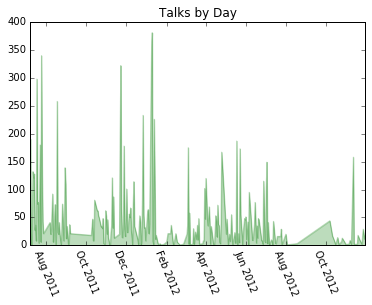

In [269]:
day = qq_group.day.value_counts().sort_index()
day.plot.area(color= 'forestgreen', alpha = 0.3, rot=-68, title = 'Talks by Day')

### QQ 群怀旧

#### 最开始说话的 10 个人
"还记得当初的我们..." 此处应有煽情怀旧BGM 😏   
好了啦，说不定人家是被拉来干活的

In [45]:
first10 = list(qq_group['id'].unique()[0:10])
print first10

['8cha0', '2cha061', '6cha437', '7cha1', '4cha387', '2cha093', '2cha847', '8cha08', '6cha584', '3cha0506']


#### 说话最多的 10 个人

In [22]:
most10 = list(qq_group['id'].value_counts().index[0:10])
print most10,

['7cha1', '6cha437', '4cha387', '8cha08', '4cha69', '1cha6531', 'acha@vip.qq.co', '2cha', '5cha8', '3cha423']


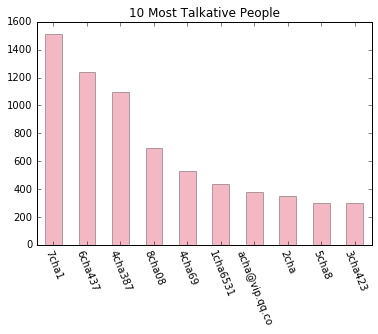

In [268]:
qq_group['id'].value_counts()[0:10].plot.bar(color='crimson', alpha=0.3,rot=-68, title='10 Most Talkative People')

#### 最初的10 个人中，有多少个是说话最多的群成员
这 4 个人还挤进了话痨排行榜前 5 ...

In [107]:
print list(set(first10).intersection(set(most10)))

['4cha387', '8cha08', '6cha437', '7cha1']


#### 活跃天数最多的 10 个人

In [259]:
most_d = qq_group.groupby('id').day.nunique().sort_values(ascending=False)
most_days = list(most_d[0:10].index)
print most_days[0:10],

['6cha437', '4cha387', '7cha1', 'acha@vip.qq.co', '4cha69', '2cha', '8cha08', '1cha45', '1cha5900', '8cha0']


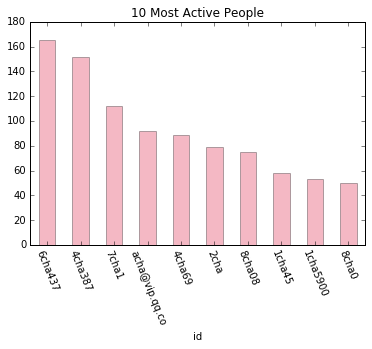

In [271]:
most_d[0:10].plot.bar(color='crimson', alpha=0.3,rot=-68, title= '10 Most Active People')

#### 最初10个人中，有多少人一直聊了下去呢
和最初话痨的4人相比，最初马拉松多出了一个8cha0    
有意思的是，8cha0是群里第一个说话的人诶，不爱说话，但也坚持到了最后...   
#### 同时也说明，这5个人当中，至少有一个人是群主吶
寻找群主的条件 (以下排名分先后)：第一天就说话了；活跃天数排名靠前；说话灰常多

In [109]:
print list(set(first10).intersection(set(most_days)))

['7cha1', '8cha0', '8cha08', '6cha437', '4cha387']
